## 9.9 Seasonal ARIMA models
ARIMA models are also capable of modelling a wide range of seasonal data.

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:
$$
\text{ARIMA} \quad
\underbrace{(p, d, q)}_{\text{Non-seasonal part of the model}}
\quad
\underbrace{(P, D, Q)_m}_{\text{Seasonal part of the model}}
$$
where $m=$ the seasonal period (e.g. number of observations per year). We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model.

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period. For example, an $\text{ARIMA}(1,1,1)(1,1,1)_4$ model (without a constant) is for quarterly data ($m=4$), and can be written as
$$
(1-\phi_1B)(1-\Phi_1B^4)(1-B)(1-B^4)y_t = (1+\theta_1B)(1+\Theta_1B^4)\varepsilon_t.
$$
The additional seasonal terms are simply multiplied by the non-seasonal terms.

### ACF/PACF
The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an $\text{ARIMA}(0,0,0)(0,0,1)_{12}$ model will show:
- a spike at lag 12 in the ACF but no other significant spike;
- exponential decay in the seasonal lags of the PACF (i.e. at lags 12, 24, 36,...)

Similarly, an $\text{ARIMA}(0,0,0)(1,0,0)_{12}$ model will show:
- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.

In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

The modelling procedure is almost the same as for non-seasonal data, except that we need to select seasonal AR and MA terms as well as the non-seasonal components of the model. The process is best illustrated via examples.

### Example: Monthly US leisure and hospitality employment
We will describe seasonal ARIMA modelling using monthly US employment data for leisure and hospitality jobs from January 2001 to September 2019.

In [1]:
import sys
sys.path.append('..')
from utils import *
from get_data import us_employment

In [6]:
leisure = (
    us_employment.query(
        'Title=="Leisure and Hospitality" and Month > "2000-01-01"'
    ).assign(Employed=us_employment["Employed"] / 1000.0)
    .set_index('Month')
)

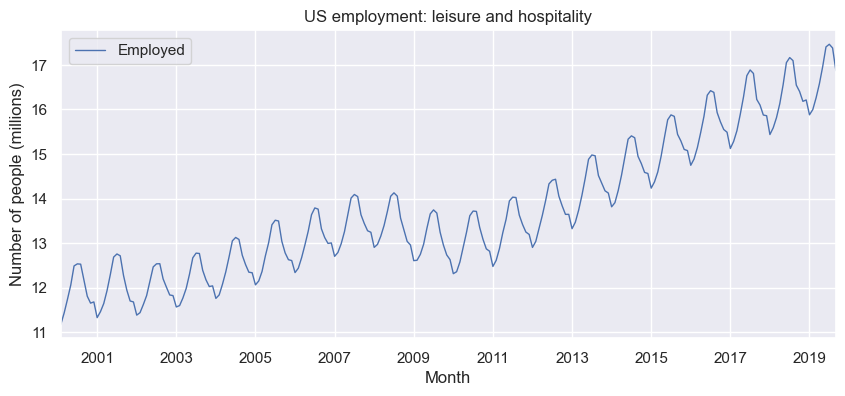

In [11]:
f, ax = plt.subplots(figsize=(10, 4))
leisure.plot(ax=ax)
ax.set(title='US employment: leisure and hospitality', ylabel='Number of people (millions)');

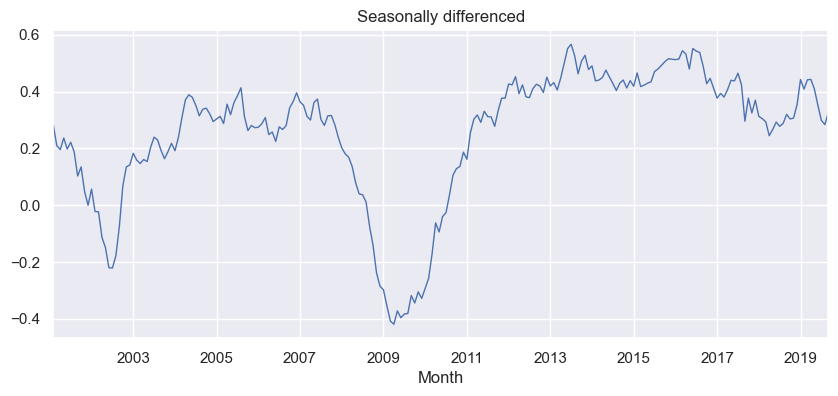

In [17]:
leisure['Employed'].diff(12).dropna().plot(title='Seasonally differenced', figsize=(10, 4));

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

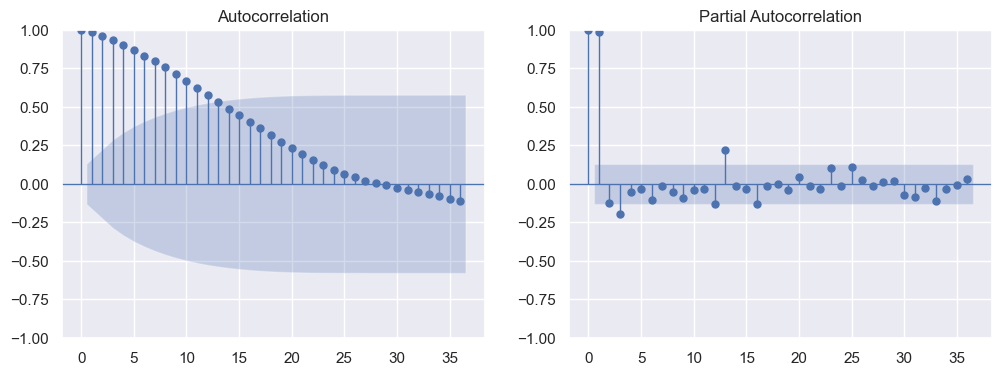

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(leisure['Employed'].diff(12).dropna(), ax=axes[0], lags=36)
plot_pacf(leisure['Employed'].diff(12).dropna(), ax=axes[1], lags=36);

The seasonally differenced values are clearly non-stationary, so we take a further first difference.

In [25]:
double_diff = leisure['Employed'].diff(12).diff().dropna()

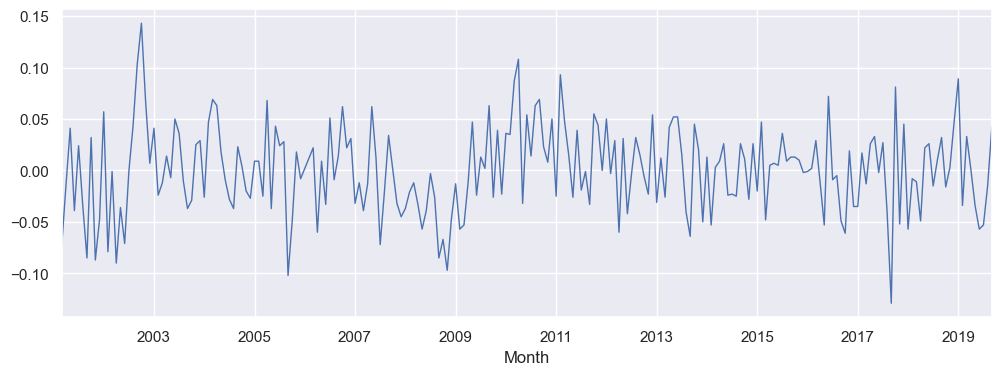

In [32]:
double_diff.plot(figsize=(12,4));

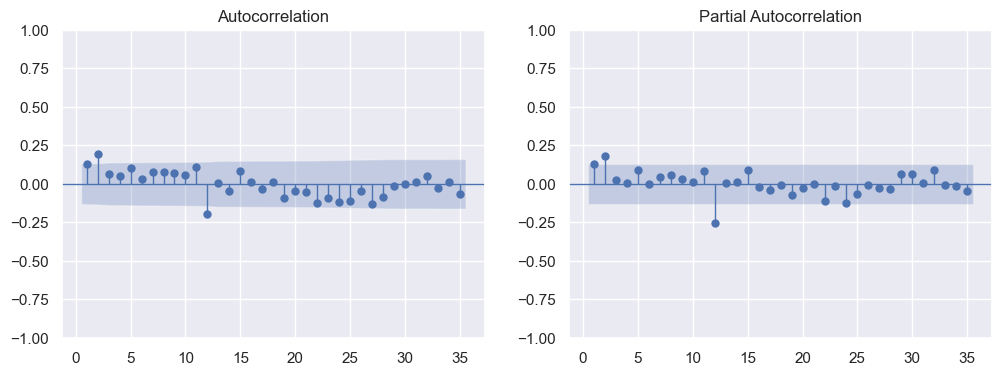

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(double_diff, ax=axes[0], lags=np.r_[1:36])
plot_pacf(double_diff, ax=axes[1], lags=np.r_[1:36]);

We want to find an appropriate ARIMA model based on the ACF and PACF show in the above figures. The significant spike at lag 2 in the ACF suggests a non-seasonal MA(2) component. The significant spike at lag 12 in the ACF suggests a seasonal MA(1) component. Consequently, we begin with an $\text{ARIMA}(0,1,2)(0,1,1)_{12}$ model, indicating a first difference, a seasonal difference and non-seasonal MA(2) and seasonal MA(1) component.

#### AutoARIMA using `statsforecast`
Use the `statsforecast` library to fit an ARIMA model to the data.

In [34]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [118]:
season_length = 12 # Monthly data
models = [AutoARIMA(season_length=season_length)]

In [55]:
df = leisure.reset_index()[['Month', 'Employed']]
df['unique_id'] = 1
df.columns = ['ds', 'y', 'unique_id']

In [ ]:
sf = StatsForecast(df=df, models=models, freq='MS', n_jobs=-1)
sf.fit()

In [42]:
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(1,1,1)(0,1,2)[12]                   '

The automation process gave us that the best model found is a model of the form `ARIMA(1,1,1)(0,1,2)[12]`. 

In [43]:
results = sf.fitted_[0, 0].model_

In [44]:
residual = pd.DataFrame(results.get('residuals'), columns=['residual'])

In [113]:
def plot_residuals(residuals, lags=24):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals");

    sns.distplot(residual, ax=axs[0,1]);
    axs[0,1].set_title("Density plot - Residual");

    stats.probplot(residual["residual"], dist="norm", plot=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')

    plot_acf(residual,  lags=np.r_[1:lags+1], ax=axs[1,1])
    axs[1,1].set_title("Autocorrelation");

    plt.show()

In [60]:
Y_hat_df = sf.forecast(h=36, fitted=True).reset_index()

In [64]:
plot_df = pd.concat([df, Y_hat_df]).set_index('ds')

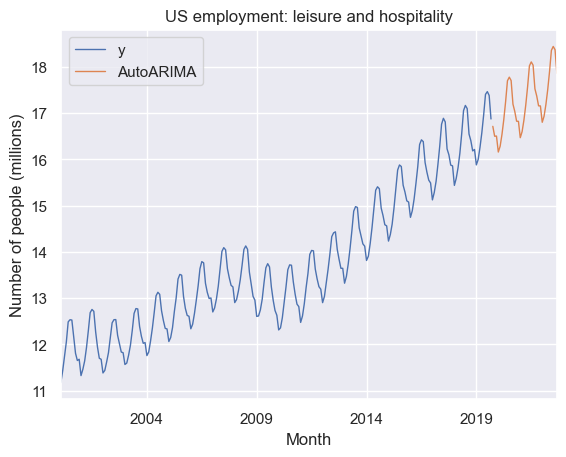

In [83]:
fig, ax = plt.subplots()
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=1)
ax.set(title='US employment: leisure and hospitality', xlabel='Month', ylabel="Number of people (millions)");

In [70]:
forecast_df = sf.predict(h=36, level = [80, 95]) 

In [73]:
df_plot = pd.concat([df, forecast_df]).set_index('ds')

In [117]:
def plot_forecast(df_plot, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    plt.plot(df_plot["y"], "k-", linewidth=1, label="y")
    plt.plot(df_plot["AutoARIMA"], "b-", color="red", linewidth=1, label="AutoArima")

    # Specify graph features:
    ax.fill_between(
        df_plot.index,
        df_plot["AutoARIMA-lo-80"],
        df_plot["AutoARIMA-hi-80"],
        alpha=0.3,
        color="b",
        label="AutoARIMA_level_80",
    )
    ax.fill_between(
        df_plot.index,
        df_plot["AutoARIMA-lo-95"],
        df_plot["AutoARIMA-hi-95"],
        alpha=0.3,
        color="g",
        label="AutoARIMA_level_95",
    )
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.legend()
    ax.grid(True)
    plt.show()


### Example: Corticosteroid drug sales in Australia

In [86]:
from get_data import PBS

In [133]:
h02 = (PBS.query('ATC2=="H02"')
    .groupby("Month", sort=False)
    .agg({"Cost": "sum"})
    .assign(Cost=lambda df: df["Cost"] / 1.0e6)
    .reset_index()
    .set_index("Month", drop=False)
    .pipe(set_freq))

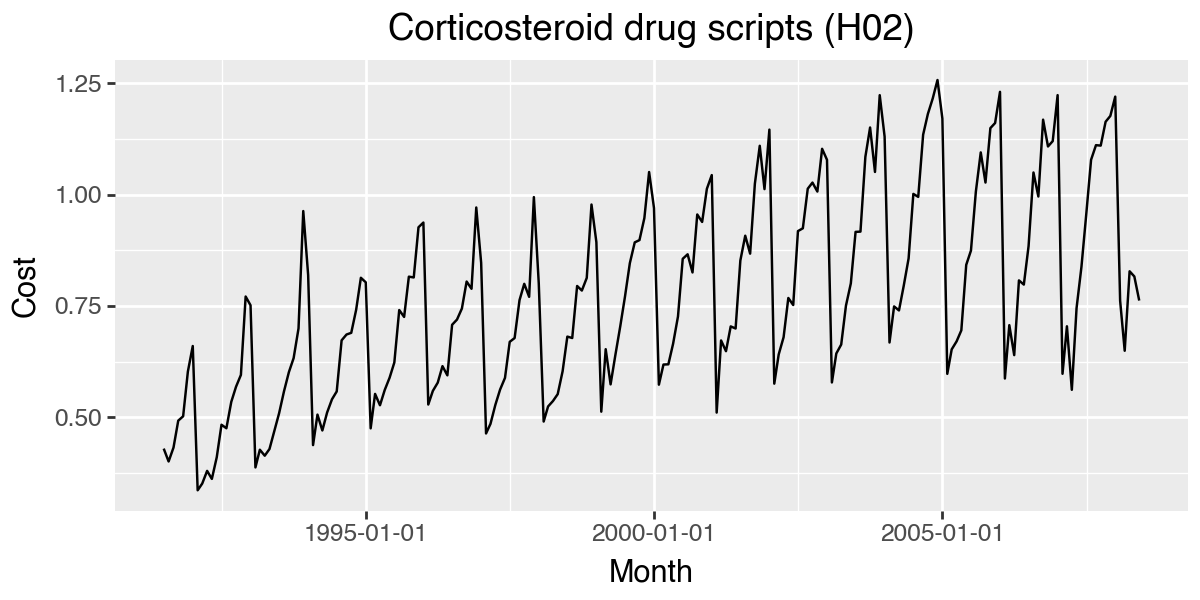

In [90]:
ggplot(h02) + aes(x='Month', y='Cost') + geom_line() + theme(figure_size=(6, 3)) + labs(title="Corticosteroid drug scripts (H02)")

In [92]:
h02_log = h02.copy()
h02_log['Cost'] = np.log(h02['Cost'])
h02_log['Type'] = 'log(Cost)'
h02['Type'] = 'Cost'

In [94]:
from plotnine import facet_grid

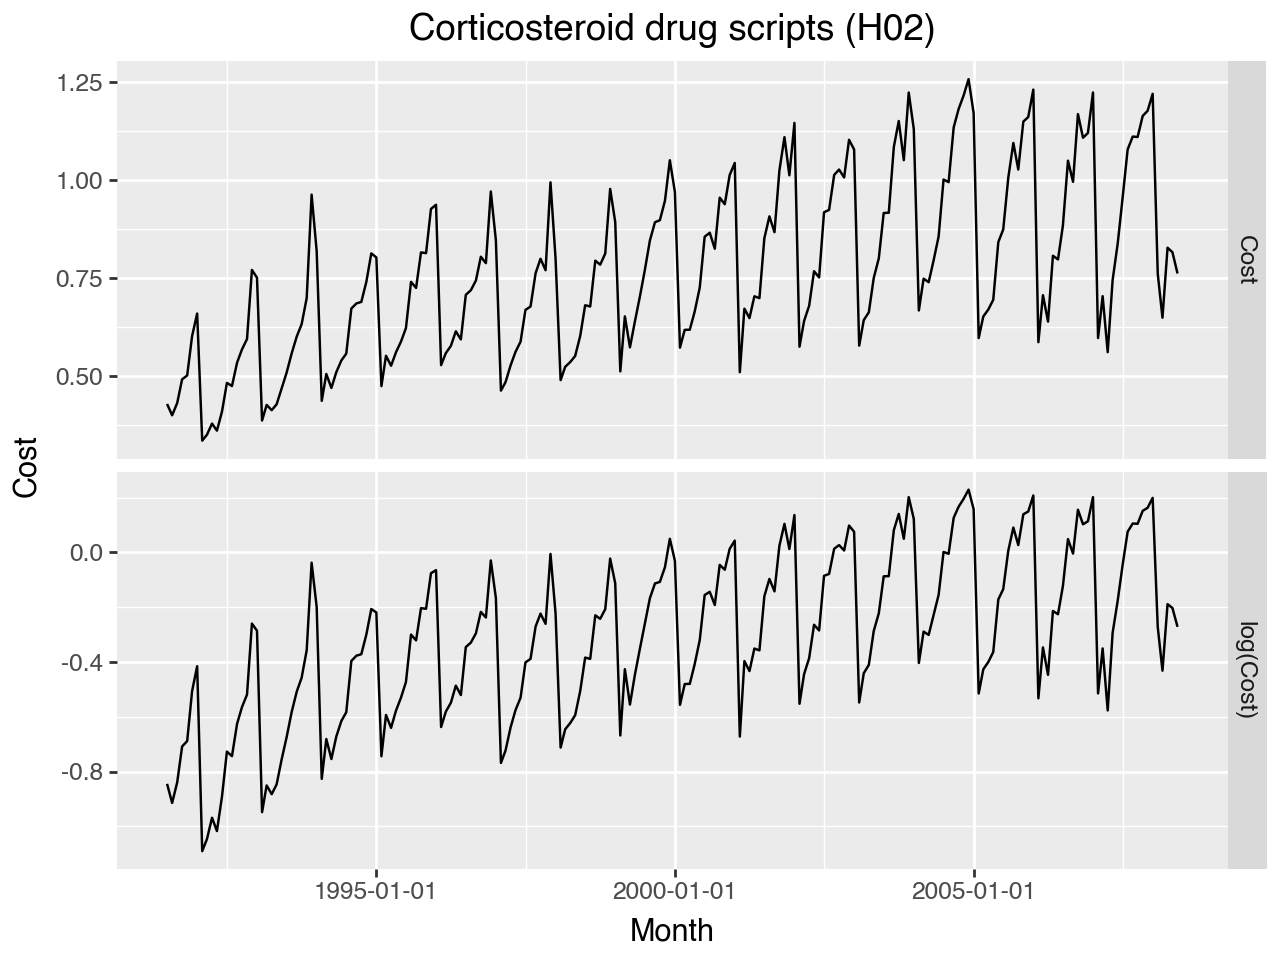

In [97]:
(
    ggplot(pd.concat([h02, h02_log]))
    + aes(x="Month", y="Cost")
    + facet_grid(rows="Type", scales="free_y")
    + geom_line()
    + labs(title='Corticosteroid drug scripts (H02)')
)


In [99]:
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

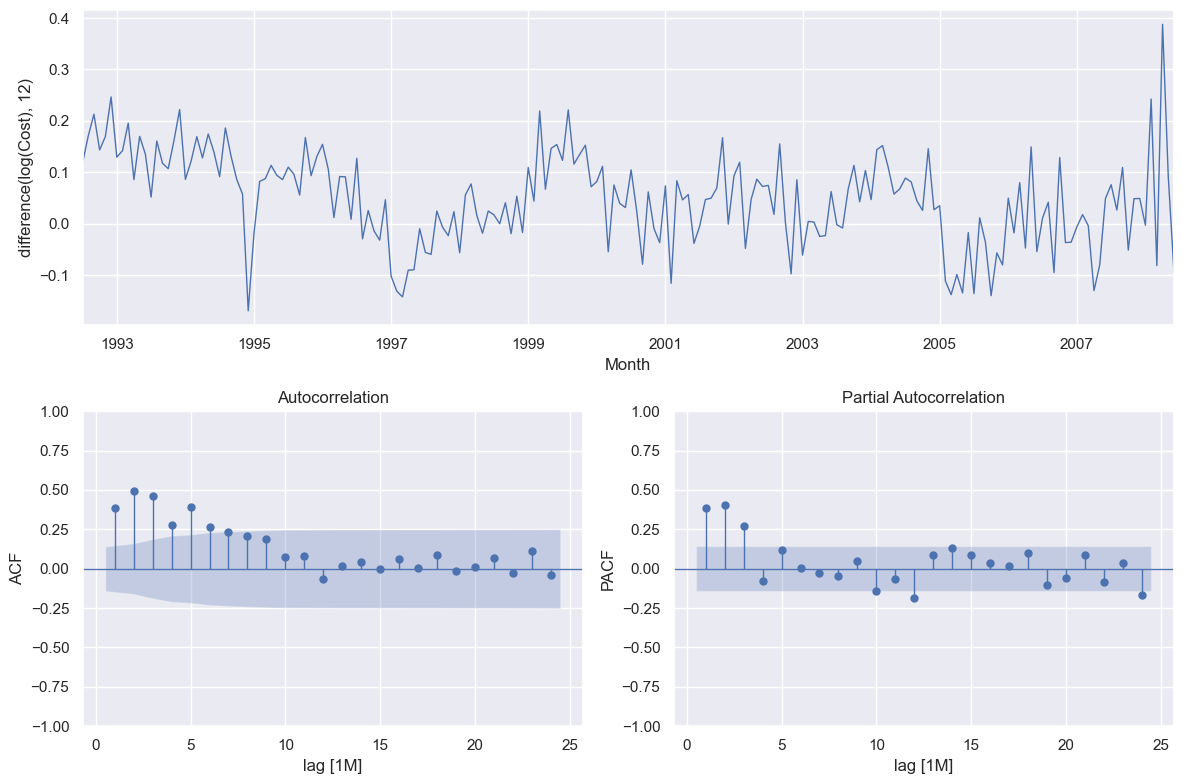

In [ ]:
plot_autocorrelations(np.log(h02.Cost).diff(12).dropna(), lags=np.r_[1:25], ylabel='difference(log(Cost), 12)')

In the plots of the seasonally differenced data, there are spikes in the PACF at lags 12 and 24, but nothing at the seasonal lags in the ACF. This may be suggestive of a seasonal AR(2) term. In the non-seasonal lags, there are three significant spikes in the PACF, suggesting a possible AR(3) term. The patterns in the ACF is not indicative of any simple model.

Consequently this initial analysis suggests that a possible model for these data is an ARIMA(3, 0, 0)(2, 1, 0)$_{12}$.

In [121]:
df_logcost = np.log(h02.Cost).reset_index()
df_logcost['unique_id'] = 1
df_logcost.columns = ['ds', 'y', 'unique_id'] # Reformat data to use statsforecast library

In [122]:
sf = StatsForecast(df=df_logcost, models=models, freq='MS', n_jobs=-1)
sf.fit()

StatsForecast(models=[AutoARIMA])

In [123]:
arima_string(sf.fitted_[0, 0].model_)

'ARIMA(2,1,3)(0,1,1)[12]                   '

So `statsforecast`'s AutoARIMA has fitted a $\text{ARIMA}(2,1,3)(0,1,1)$ model. We've kept the default parameters of `AutoARIMA`, but it could be tuned to give different results.

In [124]:
results = sf.fitted_[0, 0].model_
residuals = pd.DataFrame(results.get('residuals'), columns=['residual'])

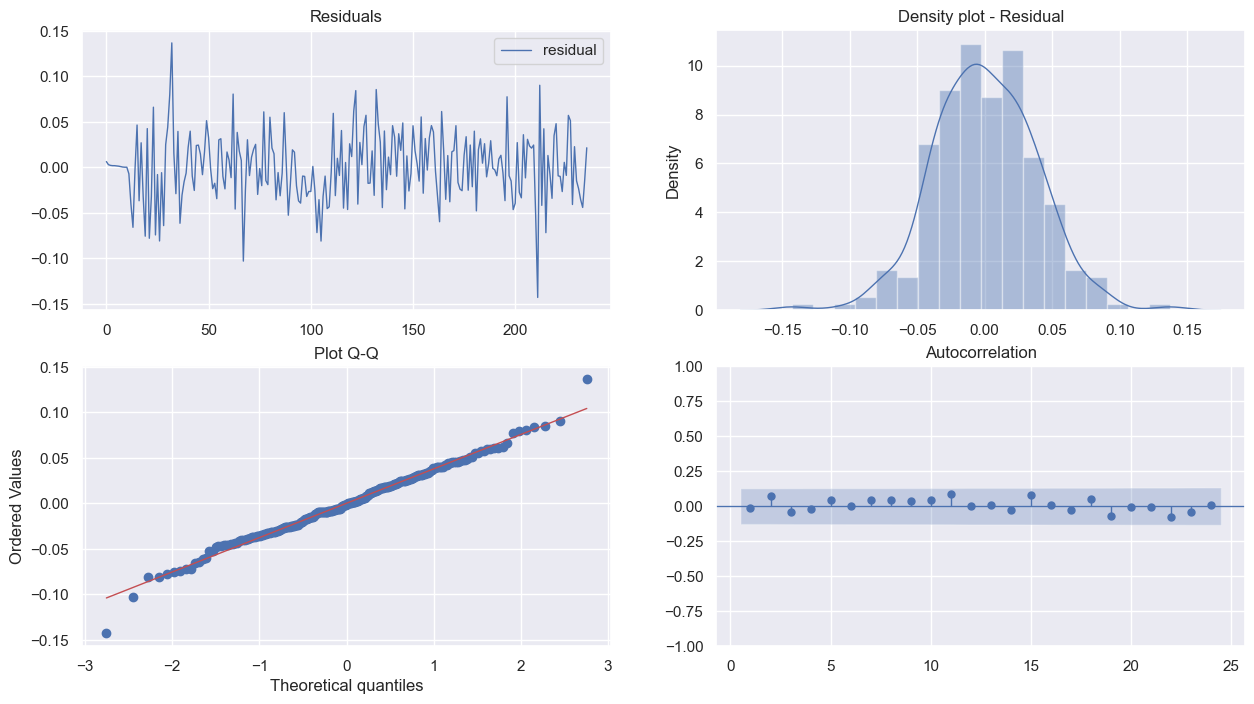

In [125]:
plot_residuals(residuals)

#### Split data into train/test
Now we use data from Jul 1991 to June 2006 to fit the model, and forecast the sales for July 2006-June 2008.

In [134]:
split = '2006-06-02'
test_end = '2008-06-02'
y_train_df, y_test_df = h02.Cost[:split], h02.Cost[split:test_end]

In [135]:
sarima_model = sm.tsa.SARIMAX(np.log1p(y_train_df), order=(3,0,1), seasonal_order=(0,1,2,12))

In [136]:
fit = sarima_model.fit(disp=0)

In [141]:
e1 = np.expm1

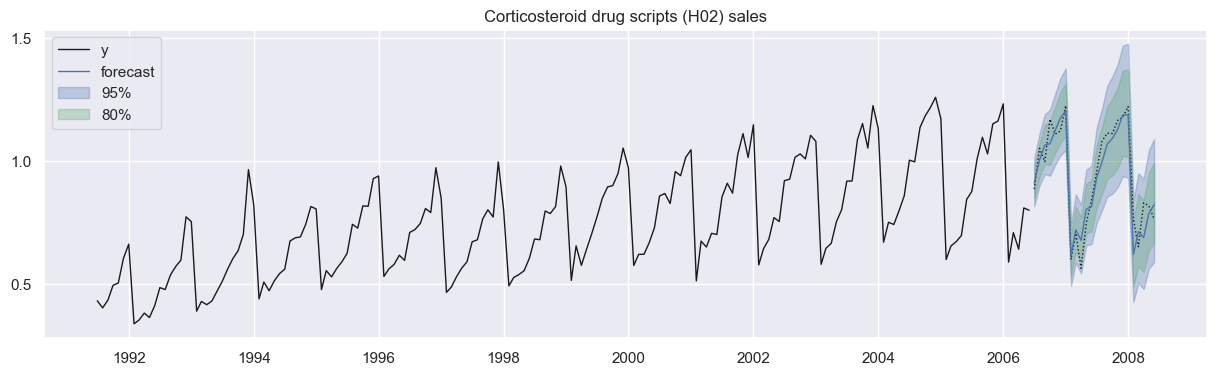

In [156]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(y_train_df, 'k', label='y')
ax.plot(y_test_df, 'k:')


fc = fit.get_forecast(2*12)
ax.plot(e1(fc.predicted_mean), label='forecast')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, e1(ci.lower), e1(ci.upper), color='C0', alpha=.3, label='95%')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, e1(ci.lower), e1(ci.upper), color='g', alpha=.3, label='80%')
ax.set(yticks=[0.5, 1, 1.5], yticklabels=[0.5, 1.0, 1.5], title='Corticosteroid drug scripts (H02) sales')
ax.legend();

In [153]:
RMSE(y_test_df, e1(fc.predicted_mean))

np.float64(0.06441029908657021)

#### Try a range of ARIMA models with different orders

In [164]:
non_seasonal = [
    (3, 0, 1),
    (3, 0, 1),
    (2, 1, 1),
    (2, 1, 2),
    (2, 1, 4),
    (2, 1, 3),
    (3, 0, 1),
    (3, 0, 2),
    (2, 1, 0),
    (3, 0, 1),
    (3, 0, 3),
    (3, 0, 2),
    (3, 0, 1),
    (2, 1, 0),
    (3, 0, 1),
    (3, 0, 0),
]
seasonal = [
    (1, 1, 1, 12),
    (0, 1, 2, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 1, 12),
    (0, 1, 3, 12),
    (0, 1, 1, 12),
    (2, 1, 0, 12),
    (2, 1, 0, 12),
    (1, 1, 0, 12),
    (1, 1, 0, 12),
    (2, 1, 0, 12),
]


In [ ]:
results = dict()
for ns, s in zip(non_seasonal, seasonal):
    label = f"ARIMA{ns}{s}"
    model = sm.tsa.SARIMAX(np.log1p(y_train_df), order=ns, seasonal_order=s)
    fit = model.fit(disp=0)
    fc = fit.get_forecast(len(y_test_df))
    error = RMSE(y_test_df, e1(fc.predicted_mean))
    results[label] = error

In [176]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['RMSE'])
print(results_df.sort_values(by='RMSE'))


                                 RMSE
ARIMA(3, 0, 1)(0, 1, 3, 12)  0.064141
ARIMA(2, 1, 1)(0, 1, 1, 12)  0.064267
ARIMA(2, 1, 4)(0, 1, 1, 12)  0.064280
ARIMA(3, 0, 1)(0, 1, 2, 12)  0.064410
ARIMA(2, 1, 2)(0, 1, 1, 12)  0.064436
ARIMA(2, 1, 0)(0, 1, 1, 12)  0.064696
ARIMA(3, 0, 3)(0, 1, 1, 12)  0.065048
ARIMA(3, 0, 2)(0, 1, 1, 12)  0.065186
ARIMA(3, 0, 1)(1, 1, 1, 12)  0.065333
ARIMA(2, 1, 3)(0, 1, 1, 12)  0.065567
ARIMA(3, 0, 1)(0, 1, 1, 12)  0.065667
ARIMA(3, 0, 2)(2, 1, 0, 12)  0.065717
ARIMA(3, 0, 1)(2, 1, 0, 12)  0.065942
ARIMA(3, 0, 0)(2, 1, 0, 12)  0.066805
ARIMA(2, 1, 0)(1, 1, 0, 12)  0.068937
ARIMA(3, 0, 1)(1, 1, 0, 12)  0.069009
